In [1]:
# Import
import torch
import torch.nn as nn
import torchvision
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
import scipy.io as sio
from scipy import signal
import glob
import pandas as pd
import numpy as np
from datetime import datetime
# Graphing
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import math

In [49]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Tensorboard
now = datetime.now()
writer = SummaryWriter('./runs/ecgclassifier' + now.strftime("%Y%m%d-%H%M%S") + "/")

In [50]:
# Hyper Parameters
input_size = 40
hidden_size = 200
num_layers = 1
num_classes = 4
num_epoch = 10
batch_size = 50
learning_rate = 0.01

In [51]:
# Visualize the data on tensorboard
ecg = sio.loadmat("./data/QTDataset/ecg1.mat")["ecgSignal"]
for i, s in enumerate(ecg[100:500]):
   writer.add_scalar('Sample Signal', s, i)

In [100]:
# Custom dataset
class ECGDataset(Dataset):
   def __init__(self, folder_path):
      """
      A dataset built off of ECG data in .mat form
      Args:
      folder_path (string): path to folder
      """
      # get image paths 
      image_list = glob.glob(folder_path+'*.mat')
      image_list.sort(key=lambda v: int(v[len("./data/QTDataset/ecg"):-4]))
      # get label paths
      label_list = glob.glob(folder_path+'*.csv')
      label_list.sort(key=lambda v: int(v[len("./data/QTDataset/ecg"):-4]))
      # Initialize the numpy arrays to store ecg and labels
      # Iterate over the labels and image_list (assume that they are of same length)
      for i in range(0, len(label_list)):
         # Load mat, filter, then convert to numpy
         ecgData = sio.loadmat(image_list[i])["ecgSignal"]
         # Calculate STFT
         w=signal.windows.kaiser(128,0.5, sym=False)
         _, _, zzx = signal.stft(ecgData.flatten(), fs=250, noverlap=127, 
                                 nperseg=128, window=w, padded=False)
         # Reshape, and take imaginary and real as separate
         zzx = zzx.reshape(-1, 65)
         zzx = np.take(zzx, range(1, 21), axis=1)
         ecgData = np.hstack([zzx.real, zzx.imag])
         # Free apparently helps with memory (after using)
         zzx = None
         # Standardize
         ecgData = (ecgData - np.mean(ecgData, axis=0))/np.std(ecgData,axis=0)
         ecgData = ecgData.astype(np.float32)
         ecgSize = ecgData.shape[0]
         trim = -1 * (ecgSize % 5000)
         # Reshape ecg into samples of 5000 ignoring whatever is left over
         ecgData = ecgData[: trim if trim != 0 else ecgSize].reshape(ecgSize // 5000, 5000)
         if i == 0:
            self.ecgs = ecgData
         else:
            self.ecgs = np.concatenate((self.ecgs, ecgData), axis=0)
         # handle the labels
         labelData = pd.read_csv(label_list[i])
         labels = np.array([0] * ecgSize)
         # Encoders to convert P, T, QRS to expected output from model
         encoder = {
            'P': 1,
            'T': 2,
            'QRS':3
            }
         for _, row in labelData.iterrows():
            labels[range(row['ROILimits_1'], row['ROILimits_2']+1)] = encoder[row['Value']]
         labels = labels[:trim if trim != 0 else ecgSize].reshape(ecgSize // 5000, 5000)
         if i == 0:
            self.labels = labels
         else:
            self.labels = np.concatenate((self.labels, labels), axis=0)
   def __getitem__(self, index):
      return torch.from_numpy(self.ecgs[index]), torch.from_numpy(self.labels[index])
   def __len__(self):
      return len(self.ecgs)

In [101]:
# Load Data
dataset = ECGDataset(r"./data/QTDataset/")
validation_split = .3
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler) 

In [90]:
# Model
class Classifier(nn.Module):
   def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(Classifier, self).__init__()
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
      self.fc = nn.Linear(hidden_size, num_classes)
      self.softmax = nn.Softmax(dim=2)
   def forward(self, x):
      # Set initial hidden and cell states
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
      c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
      lstm_out, _= self.lstm(x, (h0, c0))
      data = self.fc(lstm_out)
      out = self.softmax(data)
      return out

In [91]:
model = Classifier(input_size, hidden_size, num_layers, num_classes)

In [92]:
# Optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-3, amsgrad=True)

In [ ]:
# Train the model:
losses = []
total_step = len(train_loader)
for epoch in range(num_epoch):
   for i, (samples, labels) in enumerate(train_loader):
      model.zero_grad()

      samples = samples.reshape(-1, 5000, input_size).to(device)
      # reshape labels to match future output
      labels = labels.view(-1)
      labels = labels.to(device)
      
      # fwd pass
      outputs = model(samples)
      # Reshape to (batch_size * seq_length, C)
      outputs = outputs.view(-1, outputs.size(2))

      # Backwards
      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Write training loss
      writer.add_scalar('Training Loss', loss.item(), (epoch * total_step) + (i))
      # Write training accuracy
      _, predicted = torch.max(outputs, 1)
      correct = (predicted == labels).sum().item()
      writer.add_scalar('Training Accuracy', 100 * (correct /  labels.size(0)),
                        (epoch * total_step) + (i))
      if (i+1) % 10 == 0:
         print("Epoch [{}/{}], Step[{}/{}] Loss: {:.4f}"
               .format(epoch+1, num_epoch, i+1, total_step, loss.item()))
   # Calculate validation loss
   model.eval()
   with torch.no_grad():
      loss = 0
      for samples, labels in validation_loader:
         samples = samples.reshape(-1, 5000, input_size).to(device)
         labels = labels.view(-1).to(device)
         outputs = model(samples)
         outputs = outputs.view(-1, outputs.size(2))

         # Calculate loss and write to tensorboard
         loss += criterion(outputs, labels).item()
      writer.add_scalar('Validation Loss', loss, epoch)
   model.train()
print("Finished Training")

In [ ]:
# Save model based off of time
torch.save(model.state_dict(), 'model' + now.strftime("%Y%m%d-%H%M%S") + '.ckpt')

In [ ]:
# Load model
model.load_state_dict(torch.load('./to_validate/' + 'model' + '20200429-162615' + '.ckpt')) 

In [ ]:
# evaluate model
model.eval()
sampleCounter = 0
total_labels = []
total_predicted = []
total_signal = []
signal_counter = 0
with torch.no_grad():
   correct = 0
   total = 0
   for i, (samples, labels) in enumerate(validation_loader):
      samples = samples.reshape(-1, 5000, input_size).to(device)
      labels = labels.view(-1).to(device)
      outputs = model(samples)
      outputs = outputs.view(-1, outputs.size(2))
      # Calculate loss and write to tensorboard
      loss = criterion(outputs, labels)
      writer.add_scalar('Validation Loss', loss.item(), i)

      # Calculate correct and increment total
      _, predicted = torch.max(outputs.data, 1)
      batch_correct = (predicted == labels).sum().item()
      writer.add_scalar('Validation Accuracy', batch_correct / labels.size(0), i)
      total += labels.size(0)
      correct += batch_correct

      signal = np.dstack((
         np.arange(signal_counter, labels.size(0) + signal_counter),
         samples.flatten()))
      signal_counter += labels.size(0)
      # Save labels, predicted, and signal for graphing later
      if i == 0:
         total_signal = signal
         total_labels = labels
         total_predicted = predicted
      else:
         total_signal = np.concatenate((total_signal, signal), axis=1)
         total_labels = np.concatenate((total_labels, labels))
         total_predicted = np.concatenate((total_predicted, predicted))
   # Squeeze to remove an extra dimension
   total_signal = total_signal.squeeze()
   # hstack to form the segments
   total_signal_pairs = np.concatenate([total_signal[:-1], total_signal[1:]],
                                       axis=1)
   total_signal_pairs = total_signal_pairs.reshape(-1, 2, 2)
   np.hstack([total_signal[:-1], total_signal[1:]])
   print('Test accuracy of the model on {} samples: {}%'
         .format(total, 100 * correct / total))

In [103]:
# helper function to graph
def label2colour(labels, alpha):
   colors = np.zeros(shape=(labels.size, 4))
   encoder = {
      0: tuple([0,0,0,alpha]),
      1: tuple([1,0,0,alpha]),
      2: tuple([0,1,0,alpha]),
      3: tuple([0,0,1,alpha])
   }

   for i, l in enumerate(labels):
      colors[i] = encoder[l]
   return colors

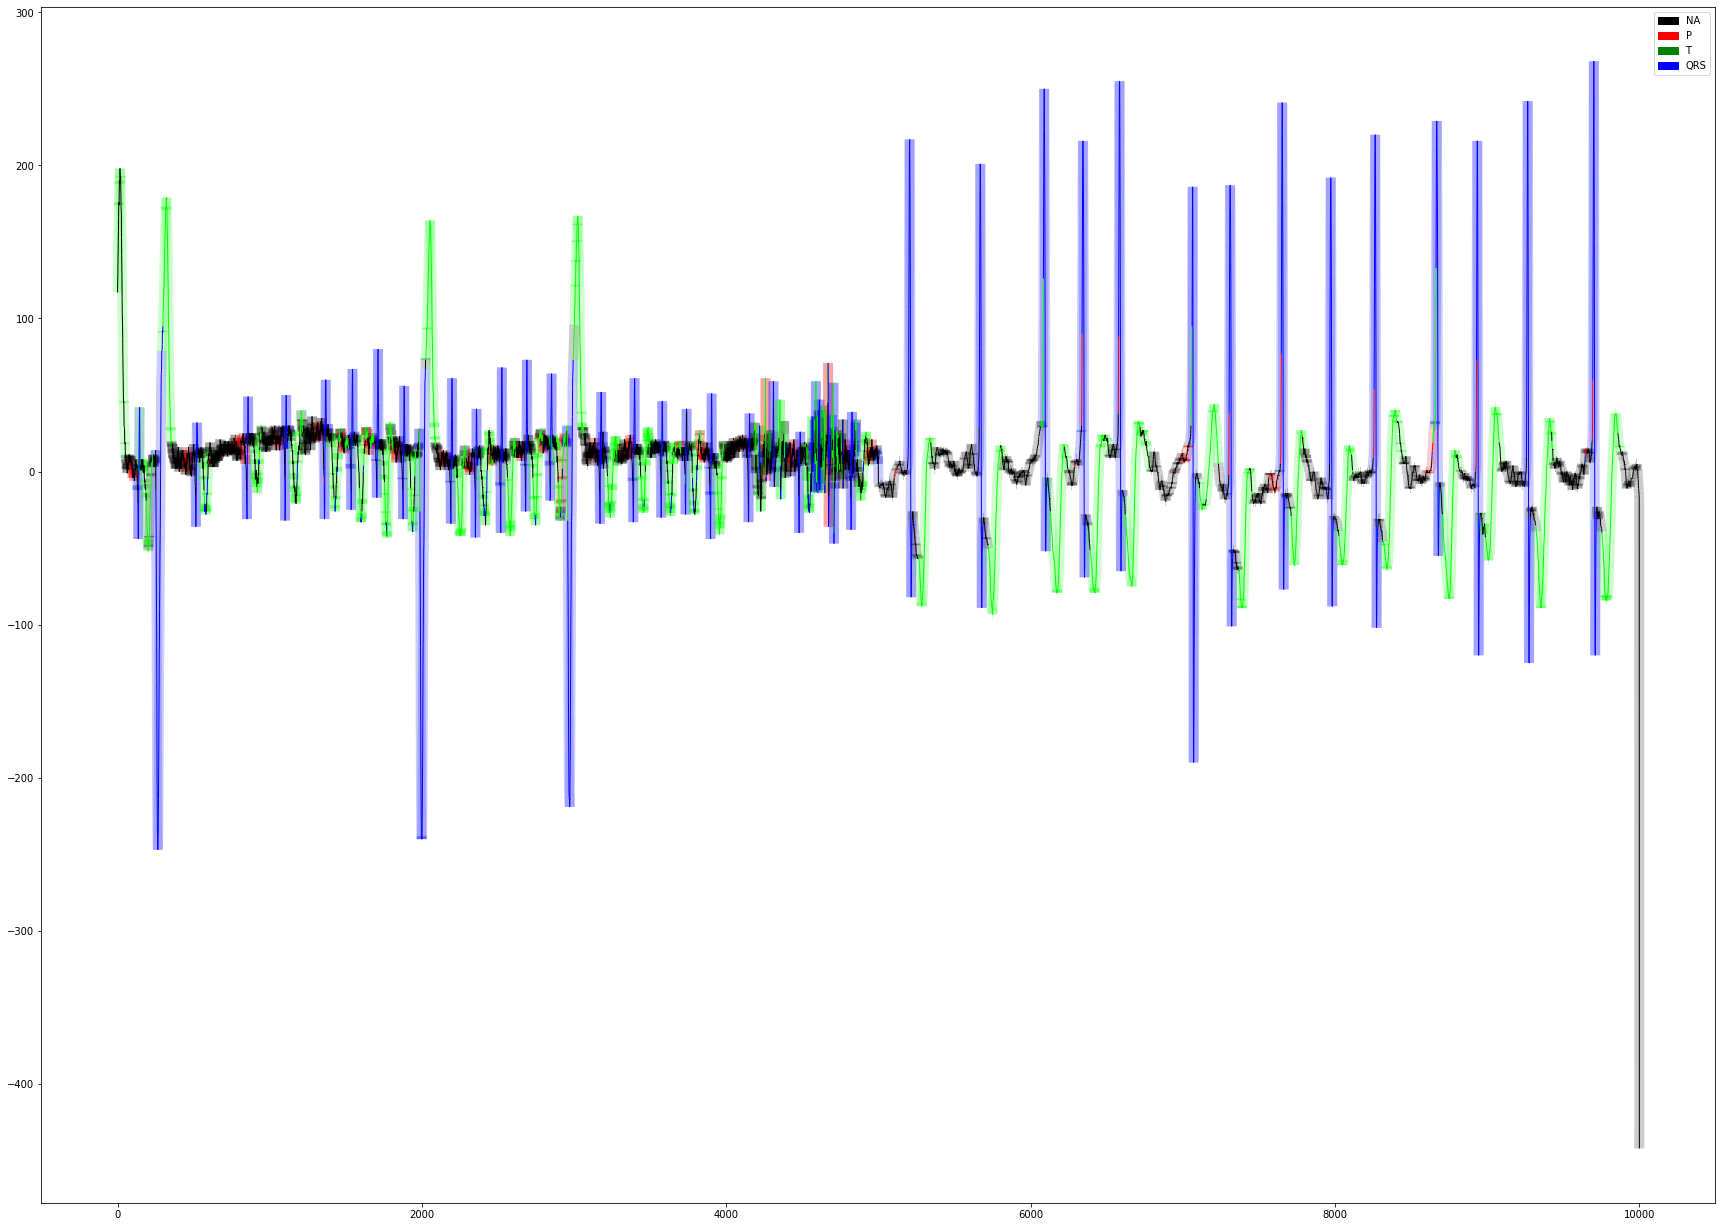

In [137]:
# Graph using data from validation
disp_signal= total_signal_pairs[0:10000]
disp_predicted = total_predicted[0:20000]
disp_labels = total_labels[0:20000]
predicted_lc = LineCollection(segments=disp_signal,
                              colors=label2colour(disp_predicted, 1),
                              linewidths=1)
true_lc = LineCollection(segments=disp_signal,
                         colors=label2colour(disp_labels, 0.2),
                         linewidths=10)
fig, ax = plt.subplots()
# Add legend
NA_patch = mpatches.Patch(color='black', label='NA')
P_patch = mpatches.Patch(color='red', label='P')
T_patch = mpatches.Patch(color='green', label='T')
QRS_patch = mpatches.Patch(color='blue', label='QRS')
plt.legend(handles=[NA_patch, P_patch, T_patch, QRS_patch])
fig.set_size_inches(30, 22)
ax.add_collection(true_lc)
ax.add_collection(predicted_lc)
ax.autoscale()
plt.show()

In [83]:
# save
fig.savefig('model_results.png', dpi = 80)

In [ ]:
# Confusion matrix
cm = confusion_matrix(total_labels, total_predicted)
cm / cm.astype(np.float).sum(axis=1)